In [1]:
import numpy as np
import scipy as sp
import netCDF4 as nC4
import scipy.signal
import nc_time_axis
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
sn.set_context("paper",font_scale=1.2)
import cartopy
from cartopy import crs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import xarray as xr
import xskillscore as xs
import os
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import sys
import glob
import datetime
import time
import multiprocessing
import zipfile
import palettable
import copy

# get my own stats functions
from mystatsfunctions import OLSE,LMoments
from moarpalettes import get_palette

from IPython.display import display, clear_output

%matplotlib inline

In [2]:
## matplotlib RCparams setup

matplotlib.rcParams['axes.prop_cycle']=matplotlib.cycler('color',list(get_palette.Petroff10().to_sn_palette()))
matplotlib.rcParams['font.family']='Helvetica Neue'
matplotlib.rcParams['legend.frameon']=False
plt.rcParams['pdf.fonttype'] = 42

In [3]:
## plotting functions:

def add_lat_lon_ticks(ax,lat=True,lon=True, lon_ext=[-180,181], lat_ext=[-90,91]):
    if lon:
        ax.set_xticks(np.arange(*lon_ext,30), crs=crs.PlateCarree())
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        ax.xaxis.set_major_formatter(lon_formatter)
    if lat:
        ax.set_yticks(np.arange(*lat_ext,10), crs=crs.PlateCarree())
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)

### get meta & lsm for ExSamples, UKCP

In [4]:
## ExSamples data location:
ExS_dataloc = '../../ExSamples_product/20210622/'

## create a run_info dataframe
run_info = pd.DataFrame(data=[['05','10','15'],['2072','2068','2066'],['r001i1p01554','r001i1p02242','r001i1p02868'],['hot','wet','hot']],
                        index=['ensemble_member','year','run','type'],columns=['fut_2072','fut_2068','fut_2066']).T

run_info['label'] = ['HOT2','WET','HOT1']

## get land sea masks
ExS_GBR_lsm = xr.open_dataarray('../ancil/ExS_GBR_lsm.nc')
UKCP_GBR_lsm = xr.open_dataarray('../ancil/UKCP_GBR_lsm.nc',decode_times=False)
UKCP_glob_lsm = xr.open_dataarray('../ancil/UKCP_lsm.nc',decode_times=False).astype(bool)

## create a dict of UKCP PPE experiment subsamples
UKCP_experiment_list = {}
UKCP_experiment_list[10] = ['0000','1113','1554','1649','1843','1935','2123','2242','2491','2868']
UKCP_experiment_list[12] = ['0000','1113','1554','1649','1843','1935','2123','2242','2305','2335','2491','2868']
UKCP_experiment_list[15] = ['0000', '0605', '0834', '1113', '1554', '1649', '1843', '1935', '2123', '2242', '2305', '2335', '2491', '2832', '2868']
UKCP_experiment_list[13] = ['0000', '0605', '0834', '1113', '1554', '1649', '1843', '1935', '2123', '2242', '2491', '2832', '2868']
UKCP_experiment_list[20] = ['0000', '0090', '0605', '0834', '1113', '1554', '1649', '1843', '1935', '2089', '2123', '2242', '2305', '2335', '2491', '2753', '2832', '2868', '2884', '2914']

## create a colour palette if required.
choose_palette = [matplotlib.colors.to_hex(get_palette.IBM_color_blind().to_sn_palette()[i]) for i in [2,0,3]]

## other options:
### IBM color blind
# [matplotlib.colors.to_hex(get_palette.IBM_color_blind().to_sn_palette()[i]) for i in [2,0,3]]
### Petroff 6
# [matplotlib.colors.to_hex(get_palette.Petroff6().to_sn_palette()[i]) for i in [1,0,2]]
### tab10
# [matplotlib.colors.to_hex(get_palette.tab10().to_sn_palette()[i]) for i in [1,0,2]]

winter_colors = pd.Series(index=['1554','2242','2868'],data=choose_palette)

## Get data

UKCP mslp for each winter

In [5]:
def preproc_UKCP_psl(ds):
    # select area used for analogs
    ds = ds.squeeze().sel(latitude=slice(35,70),longitude=slice(-30,20)).expand_dims('ensemble_member_id')
    # average over DJF
    ds = ds.sel(time = ds['time.month'].isin([12,1,2])).resample(time='QS-DEC').mean()
    ds = ds.sel(time = ds['time.month']==12)
    # reassign ensemble member ids for easy slicing
    ds = ds.assign_coords(ensemble_member_id=[x[-4:].decode() for x in ds.ensemble_member_id.values.tolist()])
    return ds

UKCP_psl = xr.open_mfdataset(['/badc/ukcp18/data/land-gcm/global/60km/rcp85/'+x+'/psl/mon/latest/psl_rcp85_land-gcm_global_60km_'+x+'_mon_189912-209911.nc' for x in run_info.ensemble_member.values],preprocess=preproc_UKCP_psl)

ExSamples mslp

In [6]:
def preproc_ExS_psl(ds):
    # rename coords to conventional
    ds=ds.squeeze().rename({'latitude4':'latitude','longitude4':'longitude','time1':'time','item16222_daily_mean':'psl'})
    # select area used for analogs
    ds=ds.sel(time=ds['time.month'].isin([12,1,2]),latitude=slice(71,34),longitude=slice(-31,21))
    # average over DJF
    ds=ds.resample(time='QS-DEC').mean()
    ds = ds.sel(time = ds['time.month']==12)
    # interpolate onto UKCP grid (which is very marginally different)
    ds=ds.interp(latitude=UKCP_psl.latitude,longitude=UKCP_psl.longitude)
    return ds.squeeze()

In [7]:
## read in the ExSamples data (and convert to hPa from Pa)
ExS_2868_fut = xr.open_mfdataset(glob.glob(ExS_dataloc+'HotWinter2066-r001i1p02868/NAtlanticEurope/psl_daily/*.nc'),preprocess=preproc_ExS_psl).psl/100
ExS_2242_fut = xr.open_mfdataset(glob.glob(ExS_dataloc+'WetWinter2068-r001i1p02242/NAtlanticEurope/psl_daily/*.nc'),preprocess=preproc_ExS_psl).psl/100
ExS_1554_fut = xr.open_mfdataset(glob.glob(ExS_dataloc+'HotWinter2072-r001i1p01554/NAtlanticEurope/psl_daily/*.nc'),preprocess=preproc_ExS_psl).psl/100

ExS_2868_base = xr.concat([preproc_ExS_psl(xr.open_dataset(x)) for x in glob.glob(ExS_dataloc+'BaselineWinters/NAtlanticEurope/psl_daily/*02868*.nc')],dim='ensemble_member_id').sortby('ensemble_member_id').psl/100
ExS_2242_base = xr.concat([preproc_ExS_psl(xr.open_dataset(x)) for x in glob.glob(ExS_dataloc+'BaselineWinters/NAtlanticEurope/psl_daily/*02242*.nc')],dim='ensemble_member_id').sortby('ensemble_member_id').psl/100
ExS_1554_base = xr.concat([preproc_ExS_psl(xr.open_dataset(x)) for x in glob.glob(ExS_dataloc+'BaselineWinters/NAtlanticEurope/psl_daily/*01554*.nc')],dim='ensemble_member_id').sortby('ensemble_member_id').psl/100

In [8]:
## create anomaly fields:
### UKCP
UKCP_1554_anom = (UKCP_psl.sel(ensemble_member_id='1554',time='2071').squeeze() - UKCP_psl.sel(ensemble_member_id='1554',time=slice('1996','2025')).mean('time')).psl.compute()
UKCP_2242_anom = (UKCP_psl.sel(ensemble_member_id='2242',time='2067').squeeze() - UKCP_psl.sel(ensemble_member_id='2242',time=slice('1996','2025')).mean('time')).psl.compute()
UKCP_2868_anom = (UKCP_psl.sel(ensemble_member_id='2868',time='2065').squeeze() - UKCP_psl.sel(ensemble_member_id='2868',time=slice('1996','2025')).mean('time')).psl.compute()

### ExSamples future
ExS_1554_anom = (ExS_1554_fut - ExS_1554_base.mean('ensemble_member_id')).compute()
ExS_2242_anom = (ExS_2242_fut - ExS_2242_base.mean('ensemble_member_id')).compute()
ExS_2868_anom = (ExS_2868_fut - ExS_2868_base.mean('ensemble_member_id')).compute()
### ExSamples baseline
ExS_1554_base_anom = (ExS_1554_base - ExS_1554_base.mean('ensemble_member_id')).compute()
ExS_2242_base_anom = (ExS_2242_base - ExS_2242_base.mean('ensemble_member_id')).compute()
ExS_2868_base_anom = (ExS_2868_base - ExS_2868_base.mean('ensemble_member_id')).compute()

''

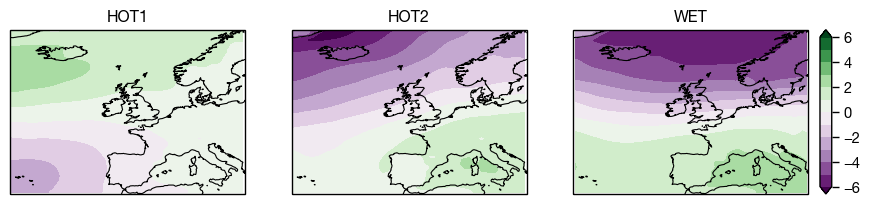

In [9]:
## BONUS FIGURE: ensemble mean mslp for the three future ensembles:
fig,ax = plt.subplots(1,3,figsize=(10.3,7/3),subplot_kw=dict(projection=crs.PlateCarree()))

p=[x.mean('ensemble_member_id').plot.contourf(ax=ax[i],extend='both',levels=np.linspace(-6,6,13),add_colorbar=False,cmap='PRGn') for i,x in enumerate([ExS_2868_anom,ExS_1554_anom,ExS_2242_anom])]

axins = inset_axes(ax[-1], width="5%",height="100%",loc='lower left',bbox_to_anchor=(1.05, 0, 1, 1),bbox_transform=ax[-1].transAxes,borderpad=0)
cbar = plt.colorbar(p[-1],cax=axins,orientation='vertical')
# cbar.set_label('sea ice fraction / %',labelpad=8)

[ax[i].set_title(x) for i,x in enumerate(['HOT1','HOT2','WET'])]
[a.coastlines() for a in ax]
[a.set_xlim(-30,20) for a in ax]
[a.set_ylim(35,70) for a in ax]

fig.dpi=100

''

In [10]:
## compute RMS error over domain
ExS_1554_distance = np.sqrt(((ExS_1554_anom-UKCP_1554_anom)**2).weighted(np.cos(np.deg2rad(ExS_1554_anom.latitude))).mean(['latitude','longitude']))
ExS_2242_distance = np.sqrt(((ExS_2242_anom-UKCP_2242_anom)**2).weighted(np.cos(np.deg2rad(ExS_2242_anom.latitude))).mean(['latitude','longitude']))
ExS_2868_distance = np.sqrt(((ExS_2868_anom-UKCP_2868_anom)**2).weighted(np.cos(np.deg2rad(ExS_2868_anom.latitude))).mean(['latitude','longitude']))

ExS_1554_base_distance = np.sqrt(((ExS_1554_base_anom-UKCP_1554_anom)**2).weighted(np.cos(np.deg2rad(ExS_1554_anom.latitude))).mean(['latitude','longitude']))
ExS_2242_base_distance = np.sqrt(((ExS_2242_base_anom-UKCP_2242_anom)**2).weighted(np.cos(np.deg2rad(ExS_2242_anom.latitude))).mean(['latitude','longitude']))
ExS_2868_base_distance = np.sqrt(((ExS_2868_base_anom-UKCP_2868_anom)**2).weighted(np.cos(np.deg2rad(ExS_2868_anom.latitude))).mean(['latitude','longitude']))

In [11]:
analog_list = pd.concat([x.sel(ensemble_member_id=(x<3)).ensemble_member_id.to_pandas() for x in [ExS_1554_distance,ExS_2242_distance,ExS_2868_distance,ExS_1554_base_distance,ExS_2242_base_distance,ExS_2868_base_distance]])

In [12]:
analog_list.to_csv('../output/data/manuscript-analogs.csv',index=False)

Alternative analog lists for testing sensitivity to threshold:

In [13]:
for threshold in np.arange(1,21):
    analog_list = pd.concat([x.sel(ensemble_member_id=(x<threshold)).ensemble_member_id.to_pandas() for x in [ExS_1554_distance,ExS_2242_distance,ExS_2868_distance,ExS_1554_base_distance,ExS_2242_base_distance,ExS_2868_base_distance]])
    analog_list.to_csv('../output/data/analog-threshold-sensitivities/analogs-'+str(threshold)+'hPa.csv',index=False)

## Plot of distances

[None, None]

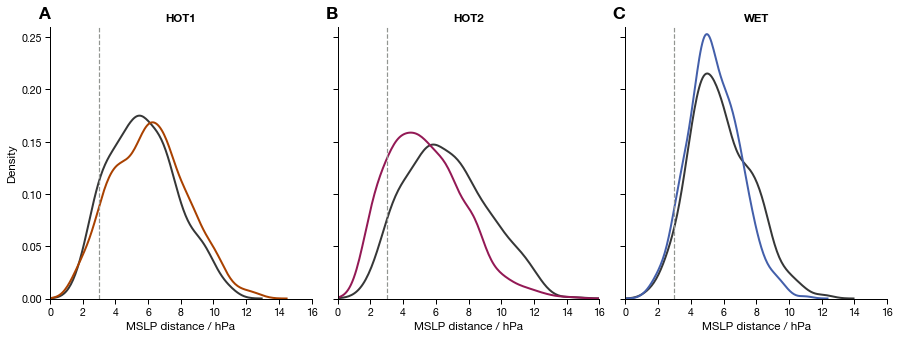

In [14]:
fig,ax = plt.subplots(1,3,figsize=(15,5),gridspec_kw=dict(wspace=0.1))

sn.kdeplot(ExS_2868_base_distance.to_pandas(),ax=ax[0],color='xkcd:dark grey',lw=2)
sn.kdeplot(ExS_2868_distance.to_pandas(),ax=ax[0],color=matplotlib.colors.to_hex(tuple(np.divide(matplotlib.colors.to_rgb(winter_colors.loc['2868']),1.5))),lw=2)

sn.kdeplot(ExS_1554_base_distance.to_pandas(),ax=ax[1],color='xkcd:dark grey',lw=2)
sn.kdeplot(ExS_1554_distance.to_pandas(),ax=ax[1],color=matplotlib.colors.to_hex(tuple(np.divide(matplotlib.colors.to_rgb(winter_colors.loc['1554']),1.5))),lw=2)

sn.kdeplot(ExS_2242_base_distance.to_pandas(),ax=ax[2],color='xkcd:dark grey',lw=2)
sn.kdeplot(ExS_2242_distance.to_pandas(),ax=ax[2],color=matplotlib.colors.to_hex(tuple(np.divide(matplotlib.colors.to_rgb(winter_colors.loc['2242']),1.5))),lw=2)

[a.axvline(3,ls='--',color='xkcd:grey') for a in ax]
[a.set_xlim(0,16) for a in ax]
[a.set_ylim(0,0.26) for a in ax]
[a.set_ylabel('') for a in ax[1:]]
[a.set_xlabel('MSLP distance / hPa') for a in ax]
[a.set_yticklabels([]) for a in ax[1:]]

[ax[i].set_title(run_info.loc[x,'label'],fontweight='bold') for i,x in enumerate(['fut_2066','fut_2072','fut_2068'])]

[ax[i].text(0.0,1.02,x,transform=ax[i].transAxes,va='bottom',ha='right',fontsize='xx-large',fontweight='bold') for i,x in enumerate(['A','B','C'])]

sn.despine()

[fig.savefig('../output/figs/SI/FIGS3.'+x,bbox_inches='tight',dpi=600) for x in ['png','pdf']]

Demonstrates that SST conditioning and dynamical conditioning are not always independent (ie. in the case of 01554)

- 01554 La Nina ENSO phase may be contributing to the more similar dynamics in that ensemble (positive NAO pattern)
- while 02868 El Nino ENSO phase may be contributing to the less similar dynamics in that ensemble (also positive NAO pattern)

## Is the SST forcing affecting the frequency of the circulation analogs?

In [15]:
def compute_analog_frequency(fut_distances,base_distances):
    
    fut_analogs = (fut_distances<3).to_pandas().sum()
    fut_tot = fut_distances.size
    
    base_analogs = (base_distances<3).to_pandas().sum()
    base_tot = base_distances.size
    
    boot_fut = np.zeros(fut_tot)
    boot_fut[:fut_analogs] = 1
    boot_fut = np.random.choice(boot_fut,boot_fut.size*100000).reshape(100000,-1).sum(axis=1) / boot_fut.size
    
    boot_base = np.zeros(base_tot)
    boot_base[:base_analogs] = 1
    boot_base = np.random.choice(boot_base,boot_base.size*100000).reshape(100000,-1).sum(axis=1) / boot_base.size
    
    boot_relative = boot_fut/boot_base
    
    print('relative frequency:',round(np.median(boot_relative),2),'[',*np.quantile(boot_relative,[0.05,0.95]).round(2),']')

In [16]:
print('01554 - 2072 - hot')
compute_analog_frequency(ExS_1554_distance,ExS_1554_base_distance)
print()
print('02242 - 2068 - wet')
compute_analog_frequency(ExS_2242_distance,ExS_2242_base_distance)
print()
print('2868 - 2066 - hot')
compute_analog_frequency(ExS_2868_distance,ExS_2868_base_distance)

01554 - 2072 - hot
relative frequency: 3.63 [ 2.6 5.4 ]

02242 - 2068 - wet
relative frequency: 1.17 [ 0.79 1.83 ]

2868 - 2066 - hot
relative frequency: 0.81 [ 0.61 1.08 ]
